# Critical Infrastructure Failures from Hurricane Michael (FL, AL, GA)

This Jupyter Notebook demonstrates the calculation flow of implementing an interdependent network model of critical infrastructures across 3 US States and its failures due to the impacts of a historic hurricane track.

The notebook is structured as follows:
* Data Loading and Pre-Processing of Networks
* 

### Data Loading and Pre-Processing of Networks

In [1]:
# standard imports
import geopandas as gpd
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle 
import shapely

In [2]:
# currently on climada_petals branch feature/networks until it will be merged into the develop & main branch of the repo
from climada_petals.engine.networks.nw_preps import NetworkPreprocess, PowerlinePreprocess, RoadPreprocess
from climada_petals.engine.networks.nw_base import Network
from climada_petals.engine.networks.nw_calcs import Graph
from climada_petals.engine.networks import nw_utils as nwu
from climada_petals.entity.exposures.openstreetmap import osm_dataloader as osm
from climada_petals.util.constants import DICT_GEOFABRIK

In [3]:
# imports from the core part of CLIMADA
from climada.hazard.base import Hazard
from climada.util import coordinates as u_coords
from climada.util import lines_polys_handler as u_lp
from climada.hazard import TropCyclone
from climada.entity.entity_def import Entity
from climada.entity.exposures.base import Exposures
from climada.engine import Impact
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet

In [5]:
# =============================================================================
# Constants & filepaths
# =============================================================================
# general paths & constants
PATH_DATA = '/cluster/work/climate/evelynm/nw_inputs/FLALGA'
PATH_SAVE = '/cluster/work/climate/evelynm/nw_outputs/FLALGA'
PATH_EL_CONS_GLOBAL = PATH_DATA +'/final_consumption_iea_global.csv'
mode = 'telemod'
if mode == '':
    path_deps = PATH_DATA + '/dependencies_FLALGA.csv'
elif mode=='telemod':
    path_deps = PATH_DATA + '/dependencies_FLALGA_telemod.csv'
elif mode=='telemod_distmod':
    path_deps = PATH_DATA + '/dependencies_FLALGA_telemod_distmod.csv'

In [6]:
# =============================================================================
# CI Data
# =============================================================================

In [7]:
# PEOPLE 
gdf_people = gpd.read_file(PATH_DATA+'/people_flalga.shp')

# POWER LINES
gdf_powerlines = gpd.read_file(PATH_DATA+'/powerlines_flalga.shp')
gdf_powerlines = gdf_powerlines[['TYPE','geometry','VOLT_CLASS', 'VOLTAGE']]
gdf_powerlines['osm_id'] = 'n/a'

# POWER PLANTS
gdf_pplants = gpd.read_file(PATH_DATA+'/powerplants_flalga.shp') 
gdf_pplants.rename({'NET_GEN':'estimated_generation_gwh_2017'}, axis=1, inplace=True)

gdf_people, gdf_pplants = nwu.PowerFunctionalData().assign_el_prod_consump(
    gdf_people, gdf_pplants, 'USA', PATH_EL_CONS_GLOBAL)

# HEALTH FACILITIES
gdf_health = gpd.read_file(PATH_DATA+'/healthfacilities_flalga.shp')

# EDUC. FACILITIES
gdf_educ = gpd.read_file(PATH_DATA+'/educationfacilities_flalga.shp') 

# TELECOM
gdf_telecom = gpd.read_file(PATH_DATA+'/celltowers_flalga.shp') 

# ROADS
gdf_mainroads_osm = gpd.read_file(PATH_DATA+'/mainroads_osm_flalga.shp') 

# WASTEWATER
gdf_wastewater = gpd.read_file(PATH_DATA+'/wastewater_flalga.shp') 

In [8]:
# Sanity Checks
print(len(gdf_powerlines), len(gdf_mainroads_osm))
# 10347 145344
print(gdf_pplants.el_generation.sum(), gdf_people.el_consumption.sum())
#13787828.0 13787828.000000002

10347 145344
13787828.0 13787828.000000002


In [9]:
# =============================================================================
# Networks Preprocessing
# =============================================================================

In [14]:
# POWER LINES

# do once, save and re-load for following runs
gdf_power_edges, gdf_power_nodes = PowerlinePreprocess().preprocess(
    gdf_edges=gdf_powerlines)
power_network = Network(gdf_power_edges, gdf_power_nodes)
power_graph = Graph(power_network, directed=False)

iter_count = 0
while (len(power_graph.graph.clusters())>1) and (iter_count<8):
    iter_count+=1
    power_graph.link_clusters(dist_thresh=200000)
power_network = Network().from_graphs([power_graph.graph.as_directed()])

# power_graph = Graph(power_network, directed=True) 
# power_graph.graph.clusters().summary(): 
# Clustering with 4173 elements and 1 clusters
# len(power_network.edges) 12318


topology: 100%|██████████| 10597/10597 [00:03<00:00, 3051.70it/s]


In [10]:
#power_network.nodes.to_feather(PATH_DATA+'/pline_processed_n')
#power_network.edges.to_feather(PATH_DATA+'/pline_processed_e')
power_network = Network(nodes=gpd.read_feather(PATH_DATA+'/pline_processed_n'),
                        edges=gpd.read_feather(PATH_DATA+'/pline_processed_e'))

In [15]:
# ROAD
gdf_road_edges, gdf_road_nodes = RoadPreprocess().preprocess(
    gdf_edges=gdf_mainroads_osm)
road_network = Network(gdf_road_edges, gdf_road_nodes)
# easy workaround for doubling edges
road_graph = Graph(road_network, directed=False)
iter_count = 0
while (len(road_graph.graph.clusters())>1) and (iter_count<4):
    iter_count+=1
    road_graph.link_clusters(dist_thresh=30000)
road_network = Network().from_graphs([road_graph.graph.as_directed()])

# road_graph = Graph(road_network, directed=True) 
# road_graph.graph.clusters().summary()
# Clustering with 52057 elements and 3 clusters'
# len(road_network.edges) 309740 
# del road_graph

topology: 100%|██████████| 185160/185160 [01:02<00:00, 2985.21it/s]


In [11]:
#road_network.nodes.to_feather(PATH_DATA+'/roads_processed_n')
#road_network.edges.to_feather(PATH_DATA+'/roads_processed_e')
road_network = Network(nodes=gpd.read_feather(PATH_DATA+'/roads_processed_n'),
                        edges=gpd.read_feather(PATH_DATA+'/roads_processed_e'))

In [12]:
# PEOPLE
__, gdf_people_nodes = NetworkPreprocess('people').preprocess(
    gdf_nodes=gdf_people)
people_network = Network(nodes=gdf_people_nodes)

# POWER PLANTS
__, gdf_pp_nodes = NetworkPreprocess('power_plant').preprocess(
    gdf_nodes=gdf_pplants)
pplant_network = Network(nodes=gpd.GeoDataFrame(gdf_pp_nodes))

# HEALTHCARE
__, gdf_health_nodes = NetworkPreprocess('health').preprocess(
    gdf_nodes=gdf_health)
health_network = Network(nodes=gdf_health_nodes)

# EDUC
__, gdf_educ_nodes = NetworkPreprocess('education').preprocess(
    gdf_nodes=gdf_educ)
educ_network = Network(nodes=gdf_educ_nodes)

# TELECOM
__, gdf_tele_nodes = NetworkPreprocess('celltower').preprocess(
    gdf_nodes=gdf_telecom)
tele_network = Network(nodes=gdf_tele_nodes)

# WASTEWATER
__, gdf_ww_nodes = NetworkPreprocess('wastewater').preprocess(
    gdf_nodes=gdf_wastewater)
wastewater_network = Network(nodes=gdf_ww_nodes)


### Creating an interdependent CI Network

In [13]:
# MULTINET
# add all CI networks into one
cis_network = Network.from_nws([pplant_network, power_network, wastewater_network,
                                      people_network, health_network, educ_network,
                                      road_network, tele_network])
cis_network.initialize_funcstates()

In [14]:
# remove unnecessary variables
for col in ['man_made', 'public_tra', 'bus']: #'TYPE','VOLT_CLASS', 'VOLTAGE',
    cis_network.edges.pop(col)
for col in ['estimated_generation_gwh_2017','name' ]:
    cis_network.nodes.pop(col)
#del pplant_network, power_network, wastewater_network, people_network, health_network, educ_network, road_network, tele_network

In [15]:
# =============================================================================
# Interdependencies
# =============================================================================

In [16]:
cis_graph = Graph(cis_network, directed=True)

In [17]:
df_dependencies = pd.read_csv(path_deps, sep=',', header=0).replace({np.nan:None})
df_dependencies.head()

,Dep,source,target,single_link,access_cnstr,type_I,type_II,thresh_func,thresh_dist
0,1,power_line,celltower,True,False,functional,physical,0.6,None
1,3,power_line,education,True,False,functional,physical,0.6,None
2,4,wastewater,education,True,False,functional,logical,1.0,None
3,6,power_line,health,True,False,functional,physical,0.6,None
4,7,wastewater,health,True,False,functional,logical,1.0,None


In [18]:
# create "missing physical structures" - needed for real world flows
cis_graph.link_vertices_closest_k('power_line', 'power_plant', link_name='power_line', bidir=True, k=1)
cis_graph.link_vertices_closest_k('road', 'people',  link_name='road', 
                                  dist_thresh=df_dependencies[
                                      df_dependencies.source=='road'].thresh_dist.values[0],bidir=True, k=5)
cis_graph.link_vertices_closest_k('road', 'health',  link_name='road',  bidir=True, k=1)
cis_graph.link_vertices_closest_k('road', 'education', link_name='road',  bidir=True, k=1)

In [19]:
# Sanity check
nwu.get_graphstats(cis_graph)

{'no_edges': 246878,
 'no_nodes': 78982,
 'edge_types': Counter({'power_line': 13232, 'road': 233646}),
 'node_types': Counter({'power_plant': 457,
          'power_line': 4173,
          'wastewater': 2570,
          'people': 6154,
          'health': 732,
          'education': 8548,
          'road': 52057,
          'celltower': 4291})}

In [20]:
# Create dependency edges in graph according to dependency df specs
for __, row in df_dependencies.iterrows():
    cis_graph.place_dependency(row.source, row.target, 
                               single_link=row.single_link,
                               access_cnstr=row.access_cnstr, 
                               dist_thresh=row.thresh_dist,
                               preselect=False)
cis_network = cis_graph.return_network()

2022-08-08 15:03:15,136 - climada_petals.engine.networks.nw_calcs - INFO - Placing dependency between power_line and celltower
2022-08-08 15:03:16,787 - climada_petals.engine.networks.nw_calcs - INFO - Placing dependency between power_line and education
2022-08-08 15:03:18,898 - climada_petals.engine.networks.nw_calcs - INFO - Placing dependency between wastewater and education
2022-08-08 15:03:20,953 - climada_petals.engine.networks.nw_calcs - INFO - Placing dependency between power_line and health
2022-08-08 15:03:22,205 - climada_petals.engine.networks.nw_calcs - INFO - Placing dependency between wastewater and health
2022-08-08 15:03:23,407 - climada_petals.engine.networks.nw_calcs - INFO - Placing dependency between power_line and wastewater
2022-08-08 15:03:24,855 - climada_petals.engine.networks.nw_calcs - INFO - Placing dependency between celltower and people
2022-08-08 15:03:29,054 - climada_petals.engine.networks.nw_calcs - INFO - Placing dependency between education and peop

In [21]:
# Sanity Check on created edge-types
set(cis_graph.graph.es['ci_type'])

{'dependency_celltower_people',
 'dependency_education_people',
 'dependency_health_people',
 'dependency_power_line_celltower',
 'dependency_power_line_education',
 'dependency_power_line_health',
 'dependency_power_line_people',
 'dependency_power_line_wastewater',
 'dependency_road_people',
 'dependency_wastewater_education',
 'dependency_wastewater_health',
 'dependency_wastewater_people',
 'power_line',
 'road'}

In [22]:
# =============================================================================
# Base State
# =============================================================================

In [23]:
# Compute functionality states of all infrastructure components and service supplies for people
cis_network.initialize_funcstates()
for __, row in df_dependencies.iterrows():
    cis_network.initialize_capacity(row.source, row.target)
for __, row in df_dependencies[
        df_dependencies['type_I']=='enduser'].iterrows():
    cis_network.initialize_supply(row.source)
cis_network.nodes.pop('name')

0            0
1            1
2            2
3            3
4            4
         ...  
78977    78977
78978    78978
78979    78979
78980    78980
78981    78981
Name: name, Length: 78982, dtype: int64

In [24]:
cis_graph = Graph(cis_network, directed=True)
cis_graph.cascade(df_dependencies, p_source='power_plant', p_sink='power_line', 
                  source_var='el_generation', demand_var='el_consumption',
                  preselect=False,initial=True)
cis_network = cis_graph.return_network()

2022-08-08 15:08:51,339 - climada_petals.engine.networks.nw_calcs - INFO - Updating functional states. Current func.-state delta : -1
2022-08-08 15:08:51,359 - climada_petals.engine.networks.nw_calcs - INFO - Checking networked ci-types {'road', 'power_line'}
2022-08-08 15:08:51,475 - climada_petals.engine.networks.nw_calcs - INFO - Updating power clusters
2022-08-08 15:08:52,465 - climada_petals.engine.networks.nw_calcs - INFO - Ended functional state update. Proceeding to end-user update.
2022-08-08 15:08:52,660 - climada_petals.engine.networks.nw_calcs - INFO - Re-calculating paths from education to people
2022-08-08 15:13:10,021 - climada_petals.engine.networks.nw_calcs - INFO - Re-calculating paths from health to people
running updated algorithm


In [25]:
# Save Base State NW
cis_network.nodes.to_feather(PATH_SAVE+f'/cis_nw_nodes_base_{mode}')
# cis_network.edges.to_feather(PATH_SAVE+f'/cis_nw_edges_base_{mode}')
# cis_network = Network(nodes = gpd.read_feather(PATH_SAVE+f'/cis_nw_nodes_base_{mode}'), 
#                      edges = gpd.read_feather(PATH_SAVE+f'/cis_nw_edges_base_{mode}'))

In [26]:
base_stats = nwu.number_noservices(cis_graph,
                         services=['power', 'healthcare', 'education', 
                                   'telecom', 'mobility','water'])

with open(PATH_SAVE +f'/base_stats_FLALGA_{mode}.pkl', 'wb') as f:
    pickle.dump(base_stats, f) 

In [27]:
print(f'Summary of people without access to basic services: {base_stats}')

Summary of people without access to basic services: {'power': 0.0, 'healthcare': 37291.64206373881, 'education': 44611.60636988122, 'telecom': 254.9133243560791, 'mobility': 37291.64206373881, 'water': 0.0}


In [28]:
# Overview Statistics on graph properties
nwu.get_graphstats(cis_graph)

{'no_edges': 498611,
 'no_nodes': 78982,
 'edge_types': Counter({'power_line': 13232,
          'road': 233646,
          'dependency_power_line_celltower': 4291,
          'dependency_power_line_education': 8548,
          'dependency_wastewater_education': 8548,
          'dependency_power_line_health': 732,
          'dependency_wastewater_health': 732,
          'dependency_power_line_wastewater': 2570,
          'dependency_celltower_people': 30755,
          'dependency_power_line_people': 6154,
          'dependency_road_people': 30108,
          'dependency_wastewater_people': 6154,
          'dependency_education_people': 6015,
          'dependency_health_people': 147126}),
 'node_types': Counter({'power_plant': 457,
          'power_line': 4173,
          'wastewater': 2570,
          'people': 6154,
          'health': 732,
          'education': 8548,
          'road': 52057,
          'celltower': 4291})}

### Impact Calculations

TC


<GeoAxesSubplot:title={'center':'TC max intensity at each point'}>

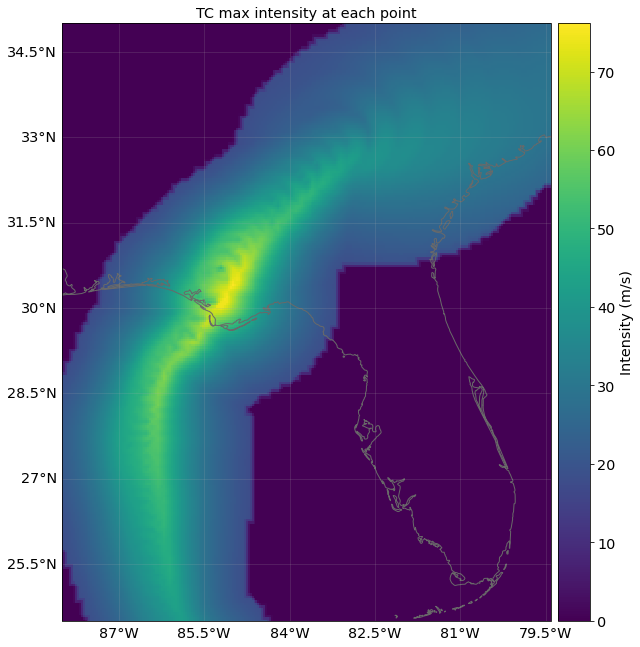

In [29]:
# =============================================================================
# Load Hazard
# =============================================================================
"""
#create from scratch as:

# get track from IBTrACS
tr_michael = TCTracks.from_ibtracs_netcdf(provider='usa', 
                                          storm_id='2018280N18273') # Michael 2018
tr_michael.equal_timestep()
ax = tr_michael.plot()
ax.set_title('TC Michael 2018')

# construct centroids
cent_flalga = Centroids().from_pnt_bounds(
    (-88, 24.5, -79.4, 35), res=0.1) 
cent_flalga.check()
cent_flalga.plot()

# compute windfield
tc_michael = TropCyclone.from_tracks(tr_michael, 
                                     centroids=cent_flalga)
"""
tc_michael = Hazard('TC').from_hdf5(PATH_DATA+'/tc_michael_1h.hdf5')
tc_michael.check()
print(tc_michael.haz_type)
tc_michael.plot_intensity(0)

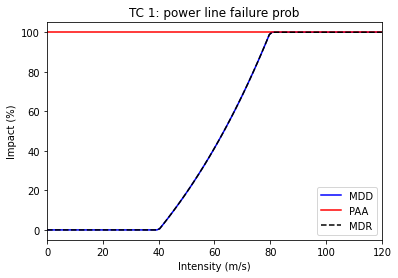

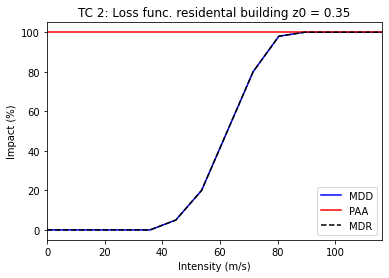

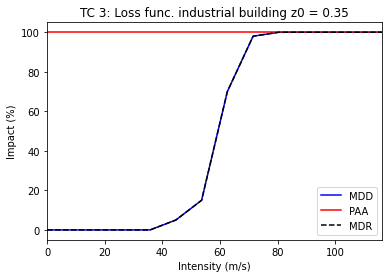

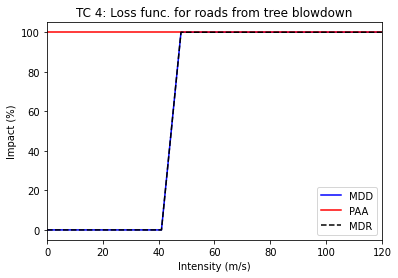

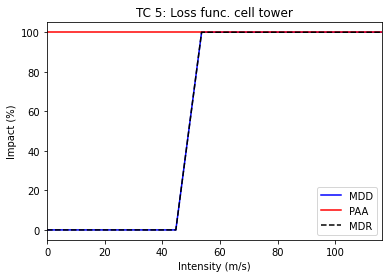

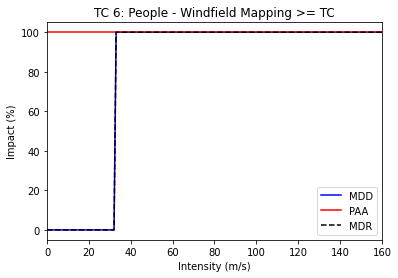

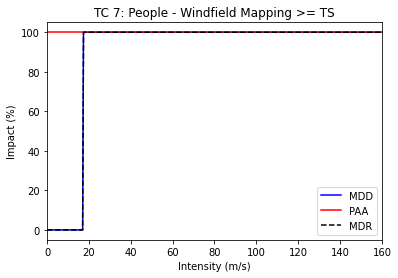

In [30]:
# =============================================================================
# Impact functions
# =============================================================================
def p_fail_pl(v_eval, v_crit=30, v_coll=60):
    """
    adapted from  https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7801854
    and Vulnerability Assessment for Power Transmission Lines under Typhoon 
    Weather Based on a Cascading Failure State Transition Diagram
    """
    p_fail = []
    for v in v_eval:
        p = 0
        if (v > v_crit) & (v < v_coll):
            p = np.exp(0.6931*(v-v_crit)/v_crit)-1
        elif v > v_coll:
            p = 1
        p_fail.append(p)
        
    return p_fail

v_eval = np.linspace(0, 120, num=120)
p_fail_powerlines = p_fail_pl(v_eval, v_crit=40, v_coll=80)

# Step func
impf_prob = ImpactFunc() 
impf_prob.id = 1
impf_prob.tag = 'PL_Prob'
impf_prob.haz_type = 'TC'
impf_prob.name = 'power line failure prob'
impf_prob.intensity_unit = 'm/s'
impf_prob.intensity = np.array(v_eval)
impf_prob.mdd = np.array(p_fail_powerlines)
impf_prob.paa = np.sort(np.linspace(1, 1, num=120))
impf_prob.check()
impf_prob.plot()

# adapted from figure H.13 (residential 2-story building) loss function, Hazus TC 2.1 (p.940)
# medium terrain roughness parameter (z_theta = 0.35)
impf_educ = ImpactFunc() 
impf_educ.id = 2
impf_educ.tag = 'TC educ'
impf_educ.haz_type = 'TC'
impf_educ.name = 'Loss func. residental building z0 = 0.35'
impf_educ.intensity_unit = 'm/s'
impf_educ.intensity = np.array([0, 30, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]) / 2.237 #np.linspace(0, 120, num=13)
impf_educ.mdd =       np.array([0, 0,   0,  0,   5,  20,  50,  80,  98, 100, 100, 100, 100]) / 100
impf_educ.paa = np.sort(np.linspace(1, 1, num=13))
impf_educ.check()
impf_educ.plot()

# adapted from figure N.1 (industrial 2 building) loss function, Hazus TC 2.1 (p.1115)
# medium terrain roughness parameter (z_theta = 0.35)
impf_indus = ImpactFunc() 
impf_indus.id = 3
impf_indus.haz_type = 'TC'
impf_indus.name = 'Loss func. industrial building z0 = 0.35'
impf_indus.intensity_unit = 'm/s'
impf_indus.intensity = np.array([0, 30, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]) / 2.237 #np.linspace(0, 120, num=13)
impf_indus.mdd =       np.array([0, 0,   0,  0,   5,  15,  70,  98, 100, 100, 100, 100, 100]) / 100
impf_indus.paa = np.sort(np.linspace(1, 1, num=13))
impf_indus.check()
impf_indus.plot()

# adapted from Koks et al. 2019 (tree blowdown on road > 42 m/s)
impf_road = ImpactFunc() 
impf_road.id = 4
impf_road.haz_type = 'TC'
impf_road.name = 'Loss func. for roads from tree blowdown'
impf_road.intensity_unit = 'm/s'
impf_road.intensity = np.array([0, 30, 41, 44.5, 48, 120])
impf_road.mdd =       np.array([0, 0,   0, 50,100, 100]) / 100
impf_road.paa = np.sort(np.linspace(1, 1, num=6))
impf_road.check()
impf_road.plot()

# adapted from newspaper articles ("cell towers to withstand up to 110 mph")
impf_tele = ImpactFunc() 
impf_tele.id = 5
impf_tele.haz_type = 'TC'
impf_tele.name = 'Loss func. cell tower'
impf_tele.intensity_unit = 'm/s'
impf_tele.intensity = np.array([0, 30, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]) / 2.237 #np.linspace(0, 120, num=13)
impf_tele.mdd =       np.array([0, 0,   0,  0,   0,  100,  100,  100, 100, 100, 100, 100, 100]) / 100
impf_tele.paa = np.sort(np.linspace(1, 1, num=13))
impf_tele.check()
impf_tele.plot()

# Mapping of wind field >= hurricane scale 1 (33 m/s)
impf_ppl = ImpactFunc() 
impf_ppl.id = 6
impf_ppl.haz_type = 'TC'
impf_ppl.name = 'People - Windfield Mapping >= TC'
impf_ppl.intensity_unit = 'm/s'
impf_ppl.intensity = np.array([0, 32, 33, 80, 100, 120, 140, 160]) 
impf_ppl.mdd = np.array([0, 0,   100,  100,   100,  100,  100,  100]) / 100
impf_ppl.paa = np.sort(np.linspace(1, 1, num=8))
impf_ppl.check()
impf_ppl.plot()

# Mapping of wind field >= Tropical Storm (17.4 m/s)
impf_ppl2 = ImpactFunc() 
impf_ppl2.id = 7
impf_ppl2.haz_type = 'TC'
impf_ppl2.name = 'People - Windfield Mapping >= TS'
impf_ppl2.intensity_unit = 'm/s'
impf_ppl2.intensity = np.array([0, 17, 17.4, 80, 100, 120, 140, 160]) 
impf_ppl2.mdd = np.array([0, 0,   100,  100,   100,  100,  100,  100]) / 100
impf_ppl2.paa = np.sort(np.linspace(1, 1, num=8))
impf_ppl2.check()
impf_ppl2.plot()

impfuncSet = ImpactFuncSet()
impfuncSet.append(impf_prob)
impfuncSet.append(impf_educ)
impfuncSet.append(impf_indus)
impfuncSet.append(impf_road)
impfuncSet.append(impf_tele)
impfuncSet.append(impf_ppl2)
ImpactFuncSet.haz_type = 'TC'


In [31]:
################
# Exposures
################

In [32]:
# POWER LINES
# 500m p point, TC func 1
res_pl = 500
exp_line = Exposures(cis_network.edges[cis_network.edges.ci_type=='power_line'])
exp_pnt = u_lp.exp_geom_to_pnt(exp_line, res=res_pl, to_meters=True, 
                               disagg_met=u_lp.DisaggMethod.FIX, disagg_val=1)  
exp_pnt.gdf[f'impf_TC'] = 1
exp_pnt.set_lat_lon()
exp_pnt.check()
entity_pl = Entity()
entity_pl.exposures.gdf = exp_pnt.gdf
entity_pl.exposures.assign_centroids(tc_michael)
entity_pl.impact_funcs = impfuncSet
entity_pl.check()

2022-08-08 15:14:33,148 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 485 coordinates.


In [33]:
# ROAD
# 500m p point, TC func 4
res_rd = 500
exp_line = Exposures(cis_network.edges[cis_network.edges.ci_type=='road'])
exp_pnt = u_lp.exp_geom_to_pnt(exp_line, res=res_rd, to_meters=True, 
                               disagg_met=u_lp.DisaggMethod.FIX, disagg_val=res_rd)  
exp_pnt.gdf[f'impf_TC'] = 4
exp_pnt.set_lat_lon()
exp_pnt.check()
entity_road = Entity()
entity_road.exposures.gdf = exp_pnt.gdf
entity_road.impact_funcs = impfuncSet
entity_road.exposures.assign_centroids(tc_michael)
entity_road.check()

In [34]:
# HEALTHCARE
entity_hc = Entity()
exp_hc = Exposures()
exp_hc.gdf = cis_network.nodes[cis_network.nodes.ci_type=='health']
exp_hc.gdf['value'] = 1
exp_hc.gdf['impf_TC'] = 3
entity_hc.exposures.gdf = exp_hc.gdf
entity_hc.exposures.set_lat_lon()
entity_hc.exposures.assign_centroids(tc_michael)
entity_hc.impact_funcs = impfuncSet
entity_hc.check()

# EDUCATION
entity_educ = Entity()
exp_educ = Exposures()
exp_educ.gdf = cis_network.nodes[cis_network.nodes.ci_type=='education']
exp_educ.gdf['value'] = 1
exp_educ.gdf['impf_TC'] = 2
entity_educ.exposures.gdf = exp_educ.gdf
entity_educ.exposures.set_lat_lon()
entity_educ.exposures.assign_centroids(tc_michael)
entity_educ.impact_funcs = impfuncSet
entity_educ.check()

# TELECOM
entity_tele = Entity()
exp_tele = Exposures()
exp_tele.gdf = cis_network.nodes[cis_network.nodes.ci_type=='celltower']
exp_tele.gdf['value'] = 1
exp_tele.gdf['impf_TC'] = 5
entity_tele.exposures.gdf = exp_tele.gdf
entity_tele.exposures.set_lat_lon()
entity_tele.exposures.assign_centroids(tc_michael)
entity_tele.impact_funcs = impfuncSet
entity_tele.check()

# WASTEWATER
entity_wwater = Entity()
exp_wwater = Exposures()
exp_wwater.gdf = cis_network.nodes[cis_network.nodes.ci_type=='wastewater']
exp_wwater.gdf['value'] = 1
exp_wwater.gdf['impf_TC'] = 3
entity_wwater.exposures.gdf = exp_wwater.gdf
entity_wwater.exposures.set_lat_lon()
entity_wwater.exposures.assign_centroids(tc_michael)
entity_wwater.impact_funcs = impfuncSet
entity_wwater.check()

# PEOPLE (for reference / validation purposes)
entity_ppl = Entity()
exp_ppl = Exposures()
exp_ppl.gdf = gdf_people.rename({'counts':'value'}, axis=1)
exp_ppl.gdf['impf_TC'] = 7
entity_ppl.exposures.gdf = exp_ppl.gdf
entity_ppl.exposures.set_lat_lon()
entity_ppl.exposures.assign_centroids(tc_michael)
entity_ppl.impact_funcs = impfuncSet
entity_ppl.check()

In [35]:
def calc_ci_impacts(hazard, exposures, impfuncSet, res_pl=500):
    """
    hazard: single event
    exposures: list of exposures
    """
    def binary_impact_from_prob(prob_vals, seed=47):
        np.random.seed = seed
        rand = np.random.random(prob_vals.size)
        return np.array([1 if p_fail > rnd else 0 for p_fail, rnd in 
                         zip(prob_vals, rand)])

    imp_list = []
    for exp in exposures:
        ci_type = exp.gdf.ci_type.iloc[0]
        imp = Impact()
        if ci_type =='road':
            imp.calc(exp, impfuncSet, hazard, save_mat=True)
            imp = u_lp.impact_pnt_agg(imp,  exp.gdf, u_lp.AggMethod.SUM)
        elif ci_type == 'power_line':
            # first convert failure probs for power line to binary failed / not failed
            imp.calc(exp, impfuncSet, hazard, save_mat=True)
            imp.imp_mat.data = binary_impact_from_prob(imp.imp_mat.data)
            # then to absolute length in metres failed
            imp.imp_mat.data = imp.imp_mat.data*res_pl    
            imp = u_lp.impact_pnt_agg(imp,  exp.gdf, u_lp.AggMethod.SUM)
        else:
            imp.calc(exp, impfuncSet, hazard)
        imp_list.append(imp)
    
    return imp_list

In [36]:
imp_list = calc_ci_impacts(tc_michael, [entity.exposures for entity in [
    entity_pl, entity_road, entity_hc, entity_educ, entity_tele, entity_wwater]],
                           impfuncSet, res_pl=500)

2022-08-08 15:18:01,887 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-08-08 15:18:02,965 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-08-08 15:18:19,496 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-08-08 15:18:19,502 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-08-08 15:18:19,510 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-08-08 15:18:19,518 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


In [37]:
# impact histogram absolute impacts (failed metres of powerline)
print(np.histogram(imp_list[0].eai_exp))

# impact histogram relative impacts (failed fraction of powerlines)
print(np.histogram(imp_list[0].eai_exp/(entity_pl.exposures.gdf.groupby(level=0).size()*res_pl)))

(array([13088,    82,    28,     7,     6,     4,     9,     6,     0,
           2]), array([    0.,  4350.,  8700., 13050., 17400., 21750., 26100., 30450.,
       34800., 39150., 43500.]))
(array([12835,   117,   102,    74,    34,    43,    15,     3,     4,
           5]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


In [38]:
# impact histogram absolute impacts (failed metres of road)
print(np.histogram(imp_list[1].eai_exp))

# impact histogram relative impacts (failed fraction of roadsections per road)
print(np.histogram(imp_list[1].eai_exp/(entity_road.exposures.gdf.groupby(level=0).size()*res_rd)))

(array([231612,   1398,    458,    136,     22,     14,      2,      2,
            0,      2]), array([    0.        ,  7587.24902946, 15174.49805893, 22761.74708839,
       30348.99611786, 37936.24514732, 45523.49417679, 53110.74320625,
       60697.99223572, 68285.24126518, 75872.49029465]))
(array([220172,    972,    560,    392,    844,   1186,    382,    496,
          238,   8404]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


In [39]:
# Assign Direct Impacts to network
cis_network.edges.loc[cis_network.edges.ci_type=='power_line', 'imp_dir'] = imp_list[0].eai_exp/(entity_pl.exposures.gdf.groupby(level=0).size()*res_pl) 
# imp_list[0].eai_exp absolute impacts for Power Lines
# if converting to fraction: add /(entity_pl.exposures.gdf.groupby(level=0).size()*res_pl) 
cis_network.edges.loc[cis_network.edges.ci_type=='road', 'imp_dir'] = imp_list[1].eai_exp/(entity_road.exposures.gdf.groupby(level=0).size()*res_rd)
# imp_list[1].eai_exp absolute impacts for roads
#if converting to fraction: add  /(entity_road.exposures.gdf.groupby(level=0).size()*res_rd)
cis_network.nodes.imp_dir.loc[cis_network.nodes.ci_type=='health'] = imp_list[2].eai_exp
cis_network.nodes.imp_dir.loc[cis_network.nodes.ci_type=='education'] = imp_list[3].eai_exp
cis_network.nodes.imp_dir.loc[cis_network.nodes.ci_type=='celltower'] = imp_list[4].eai_exp
cis_network.nodes.imp_dir.loc[cis_network.nodes.ci_type=='wastewater'] = imp_list[5].eai_exp

### Failure Cascades

In [40]:
# IMPACT - FUNCTIONALITY LEVEL (INTERNAL)
THRESH_PLINE = 0.01# if relative, change to 0.01, if absolute change to 500
THRESH_ROAD = 0.5 # if relative, change to 0.5, if absolute change to 1000
THRESH_HEALTH = 0.3
THRESH_EDUC = 0.3
THRESH_WW = 0.3
THRESH_CT = 0.3

# Assign internal functionality level to network components
cond_fail_pline = ((cis_network.edges.ci_type=='power_line') & 
                   (cis_network.edges.imp_dir>=THRESH_PLINE))

cond_fail_road = ((cis_network.edges.ci_type=='road') & 
                   (cis_network.edges.imp_dir>=THRESH_ROAD))

cond_fail_health = ((cis_network.nodes.ci_type=='health') & 
                   (cis_network.nodes.imp_dir>THRESH_HEALTH))

cond_fail_educ = ((cis_network.nodes.ci_type=='educ') & 
                   (cis_network.nodes.imp_dir>THRESH_EDUC))

cond_fail_wwater = ((cis_network.nodes.ci_type=='wastewater') & 
                   (cis_network.nodes.imp_dir>THRESH_WW))

cond_fail_tele = ((cis_network.nodes.ci_type=='celltower') & 
                   (cis_network.nodes.imp_dir>THRESH_CT))

for fail_cond in [cond_fail_pline, cond_fail_road]:
    cis_network.edges.func_internal.loc[fail_cond] = 0

for fail_cond in [cond_fail_health, cond_fail_educ, cond_fail_wwater, 
                  cond_fail_tele]:
    cis_network.nodes.func_internal.loc[fail_cond] = 0

# Update total functional states
cis_network.edges['func_tot'] = [np.min([func_internal, func_tot]) 
                                 for func_internal, func_tot in 
                                 zip(cis_network.edges.func_internal, 
                                     cis_network.edges.func_tot)]

cis_network.nodes['func_tot'] = [np.min([func_internal, func_tot]) 
                                 for func_internal, func_tot in 
                                 zip(cis_network.nodes.func_internal, 
                                     cis_network.nodes.func_tot)]


In [41]:
print(f''' Prior to cascade:
      Failed Power Line elements: {sum(cond_fail_pline)}, 
      Failed Road elements: {sum(cond_fail_road)},
      Failed hospitals: {sum(cond_fail_health)},
      Failed schools: {sum(cond_fail_educ)},
      Failed Celltowers: {sum(cond_fail_tele)},
      Failed Water Plants: {sum(cond_fail_wwater)}''')

 Prior to cascade:
      Failed Power Line elements: 527, 
      Failed Road elements: 10706,
      Failed hospitals: 7,
      Failed schools: 0,
      Failed Celltowers: 206,
      Failed Water Plants: 96


In [42]:
###################
# Impact Cascade
###################

In [43]:
cis_network.nodes.pop('name')
graph_disr = Graph(cis_network, directed=True)
graph_disr.cascade(df_dependencies, p_source='power_plant', p_sink='power_line', 
                          source_var='el_generation', demand_var='el_consumption', 
                          preselect=False)

2022-08-08 15:18:33,897 - climada_petals.engine.networks.nw_calcs - INFO - Updating functional states. Current func.-state delta : -1
2022-08-08 15:18:33,917 - climada_petals.engine.networks.nw_calcs - INFO - Checking networked ci-types {'road', 'power_line'}
2022-08-08 15:18:34,032 - climada_petals.engine.networks.nw_calcs - INFO - Updating power clusters
2022-08-08 15:18:35,032 - climada_petals.engine.networks.nw_calcs - INFO - Updating functional states. Current func.-state delta : 3573
2022-08-08 15:18:35,064 - climada_petals.engine.networks.nw_calcs - INFO - Checking networked ci-types {'road', 'power_line'}
2022-08-08 15:18:35,186 - climada_petals.engine.networks.nw_calcs - INFO - Updating power clusters
2022-08-08 15:18:36,105 - climada_petals.engine.networks.nw_calcs - INFO - Updating functional states. Current func.-state delta : 16
2022-08-08 15:18:36,137 - climada_petals.engine.networks.nw_calcs - INFO - Checking networked ci-types {'road', 'power_line'}
2022-08-08 15:18:36,

In [44]:
# save selected impact results as dataframe
cis_network = graph_disr.return_network()
vars_to_keep_edges = ['ci_type', 'func_internal', 'func_tot', 'imp_dir','geometry']
vars_to_keep_nodes = vars_to_keep_edges.copy() 
vars_to_keep_nodes.extend([colname for colname in cis_network.nodes.columns 
                                   if 'actual_supply_' in colname])
vars_to_keep_nodes.extend(['counts'])
df_res = cis_network.nodes[cis_network.nodes.ci_type=='people'][vars_to_keep_nodes]
for ci_type in ['health', 'education', 'celltower', 'power_plant', 'wastewater']:
    df_res = df_res.append(cis_network.nodes[cis_network.nodes.ci_type==ci_type][vars_to_keep_nodes])
for ci_type in ['power_line', 'road']:
        df_res = df_res.append(cis_network.edges[cis_network.edges.ci_type==ci_type][vars_to_keep_edges])
df_res.to_feather(PATH_SAVE+f'/cascade_results_{mode}')

In [45]:
# save people's service impacts as dict
disaster_stats = nwu.disaster_impact_allservices(cis_graph, graph_disr,
                services=['power', 'healthcare', 'education', 'telecom', 'mobility', 'water'])
with open(PATH_SAVE+f'/disaster_stats_{mode}.pkl', 'wb') as f:
         pickle.dump(disaster_stats, f)

In [46]:
print(f'Number of people loosing access to basic services due to TC: {disaster_stats}')

Number of people loosing access to basic services due to TC: {'power': 1222393.2611204945, 'healthcare': 808980.7721813582, 'education': 1082257.159295734, 'telecom': 1010831.8469913565, 'mobility': 754976.4504514858, 'water': 1218349.8105843626}


In [47]:
# if needed, save entire graph (not recommended)
# graph_disr.graph.write(PATH_SAVE+'/disr_graph_telemod.graphml', format='graphml')

In [48]:
# save entire network as dataframes
cis_network.nodes.to_feather(PATH_SAVE+f'/cis_nw_nodes_{mode}_tcimpacts')
cis_network.edges.to_feather(PATH_SAVE+f'/cis_nw_edges_{mode}_tcimpacts')

In [49]:
# Sanity checks before - after
print(nwu.get_graphstats(cis_graph))
print(f'\n')
print(f'\n')
print(nwu.get_graphstats(graph_disr))

{'no_edges': 498611, 'no_nodes': 78982, 'edge_types': Counter({'road': 233646, 'dependency_health_people': 147126, 'dependency_celltower_people': 30755, 'dependency_road_people': 30108, 'power_line': 13232, 'dependency_power_line_education': 8548, 'dependency_wastewater_education': 8548, 'dependency_power_line_people': 6154, 'dependency_wastewater_people': 6154, 'dependency_education_people': 6015, 'dependency_power_line_celltower': 4291, 'dependency_power_line_wastewater': 2570, 'dependency_power_line_health': 732, 'dependency_wastewater_health': 732}), 'node_types': Counter({'road': 52057, 'education': 8548, 'people': 6154, 'celltower': 4291, 'power_line': 4173, 'wastewater': 2570, 'health': 732, 'power_plant': 457})}




{'no_edges': 484629, 'no_nodes': 78982, 'edge_types': Counter({'road': 233646, 'dependency_health_people': 133708, 'dependency_celltower_people': 30755, 'dependency_road_people': 30108, 'power_line': 13232, 'dependency_power_line_education': 8548, 'dependency_wastew

### Consistency Checks

In [75]:
# consistency checks (manual)
""" 
vs_ppl_base_no_health = graph_base.graph.vs.select(ci_type='people').select(actual_supply_health_people_lt=1)
vs_ppl_base = graph_base.graph.vs.select(ci_type='people')
vs_ppl_base.select(name=7222)[0]
hosp_edges = [es.index for es in vs_ppl_base.select(name=7222)[0].incident('in')]
hosps = [hosp_edge.source for hosp_edge in graph_base.graph.es[hosp_edges]]
hosp_dict = {}
for hosp in hosps:
    hosp_dict[hosp] = [graph_base.graph.vs[hosp]['func_tot'], 
                       graph_disr.graph.vs[hosp]['func_tot']]
graph_base.graph.es[266288].source
graph_base.graph.vs[13385]
graph_disr.graph.vs[13385]

graph_disr.graph.vs.select(name=266288)[0]

vs_ppl = graph_disr.graph.vs.select(ci_type='people')
vs_ppl_no_health = vs_ppl.select(actual_supply_health_people_lt=1)
vs_ppl_no_health[0].index
vs_ppl_no_health[0].incident('out')
vs_ppl_no_health[0].incident('in')
"""

In [158]:
vs_ppl_base = cis_graph.graph.vs.select(ci_type='people')
vs_ppl_disr = graph_disr.graph.vs.select(ci_type='people')
vs_ppl_disr_nohealth = vs_ppl_disr.select(actual_supply_health_people_lt=1)

In [166]:
# check number of available hospital dependencies before and after
deps_before = []
deps_after = []
for name in vs_ppl_disr_nohealth.get_attribute_values('name'):
    es = graph_disr.graph.vs[name].incident('in')
    deps_after.append(len([edge for edge in es if edge['ci_type']=='dependency_health_people']))
    es = cis_graph.graph.vs[name].incident('in')
    deps_before.append(len([edge for edge in es if edge['ci_type']=='dependency_health_people']))


In [168]:
# consistently 0 deps. after
[(before, after) for before, after in zip(deps_before, deps_after)]

[(12, 0),
 (12, 0),
 (12, 0),
 (11, 0),
 (11, 0),
 (11, 0),
 (9, 0),
 (8, 0),
 (10, 0),
 (10, 0),
 (14, 0),
 (16, 0),
 (12, 0),
 (12, 0),
 (11, 0),
 (12, 0),
 (9, 0),
 (8, 0),
 (8, 0),
 (9, 0),
 (5, 0),
 (17, 0),
 (18, 0),
 (15, 0),
 (15, 0),
 (10, 0),
 (8, 0),
 (9, 0),
 (8, 0),
 (11, 0),
 (13, 0),
 (6, 0),
 (17, 0),
 (18, 0),
 (15, 0),
 (15, 0),
 (11, 0),
 (11, 0),
 (9, 0),
 (8, 0),
 (13, 0),
 (13, 0),
 (13, 0),
 (6, 0),
 (9, 0),
 (15, 0),
 (15, 0),
 (15, 0),
 (17, 0),
 (16, 0),
 (12, 0),
 (13, 0),
 (13, 0),
 (10, 0),
 (9, 0),
 (9, 0),
 (9, 0),
 (3, 0),
 (2, 0),
 (9, 0),
 (9, 0),
 (9, 0),
 (11, 0),
 (11, 0),
 (12, 0),
 (14, 0),
 (12, 0),
 (17, 0),
 (15, 0),
 (12, 0),
 (16, 0),
 (12, 0),
 (11, 0),
 (10, 0),
 (8, 0),
 (9, 0),
 (8, 0),
 (8, 0),
 (9, 0),
 (12, 0),
 (12, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (15, 0),
 (17, 0),
 (17, 0),
 (17, 0),
 (12, 0),
 (13, 0),
 (12, 0),
 (9, 0),
 (10, 0),
 (9, 0),
 (8, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (12, 0),
 (9, 0),
 (7,

In [190]:
# Check how many of the initially available hospitals are really dysfunctional
func_hc_before = []
func_hc_after = []

def lookup_hc_functot(graph_base, graph_disr, edge_base):
    source = graph_base.es[edge_base.index].source
    return graph_base.vs[source]['func_tot'], graph_disr.vs[source]['func_tot']
def lookup_hc_funcinter(graph_base, graph_disr, edge_base):
    source = graph_base.es[edge_base.index].source
    return graph_base.vs[source]['func_internal'], graph_disr.vs[source]['func_internal']

for name in vs_ppl_disr_nohealth.get_attribute_values('name'):
    es = cis_graph.graph.vs[name].incident('in')
    es = [edge for edge in es if edge['ci_type']=='dependency_health_people']
    func_hctot_bef = 0
    func_hctot_aft = 0
    func_hcint_bef = 0
    func_hcint_aft = 0
    for edge in es:
        func_hctot_bef += lookup_hc_functot(cis_graph.graph, graph_disr.graph, edge)[0] 
        func_hctot_aft += lookup_hc_functot(cis_graph.graph, graph_disr.graph, edge)[1]
        func_hcint_bef += lookup_hc_funcinter(cis_graph.graph, graph_disr.graph, edge)[0]
        func_hcint_aft += lookup_hc_funcinter(cis_graph.graph, graph_disr.graph, edge)[1]
    
    func_hc_before.append((func_hctot_bef, func_hcint_bef)) 
    func_hc_after.append((func_hctot_aft, func_hcint_aft)) 

In [191]:
# quite a few hospitals still functioning, hence road access must be the cause of inaccessibility
[(before, after) for before, after in zip(func_hc_before, func_hc_after)]

[((12, 12), (4, 12)),
 ((12, 12), (4, 12)),
 ((12, 12), (4, 12)),
 ((11, 11), (4, 9)),
 ((11, 11), (4, 9)),
 ((11, 11), (4, 9)),
 ((9, 9), (3, 8)),
 ((8, 8), (1, 5)),
 ((10, 10), (1, 6)),
 ((10, 10), (1, 6)),
 ((14, 14), (5, 14)),
 ((16, 16), (4, 16)),
 ((12, 12), (3, 12)),
 ((12, 12), (3, 12)),
 ((11, 11), (4, 9)),
 ((12, 12), (4, 10)),
 ((9, 9), (2, 8)),
 ((8, 8), (1, 7)),
 ((8, 8), (1, 5)),
 ((9, 9), (1, 5)),
 ((5, 5), (0, 1)),
 ((17, 17), (5, 17)),
 ((18, 18), (5, 18)),
 ((15, 15), (3, 15)),
 ((15, 15), (3, 15)),
 ((10, 10), (2, 10)),
 ((8, 8), (1, 7)),
 ((9, 9), (2, 8)),
 ((8, 8), (1, 7)),
 ((11, 11), (1, 10)),
 ((13, 13), (1, 12)),
 ((6, 6), (0, 2)),
 ((17, 17), (4, 17)),
 ((18, 18), (5, 18)),
 ((15, 15), (3, 15)),
 ((15, 15), (3, 15)),
 ((11, 11), (1, 10)),
 ((11, 11), (1, 10)),
 ((9, 9), (0, 8)),
 ((8, 8), (0, 7)),
 ((13, 13), (1, 12)),
 ((13, 13), (1, 12)),
 ((13, 13), (1, 12)),
 ((6, 6), (0, 2)),
 ((9, 9), (0, 5)),
 ((15, 15), (0, 11)),
 ((15, 15), (0, 11)),
 ((15, 15), (0, 1

In [199]:
hospitals = graph_disr.graph.vs.select(ci_type='health')

In [181]:
print(sum(np.array(hospitals['imp_dir'])>=0.3), 
      sum(np.array(hospitals['func_internal'])==0), 
      sum(np.array(hospitals['func_tot'])==0))

7

In [194]:
plines = graph_disr.graph.vs.select(ci_type='power_line')

In [196]:
sum(np.array(plines['func_tot'])==0)

91

In [198]:
list(graph_disr.graph.vs.select(ci_type='power_line').select(func_tot=0))

[igraph.Vertex(<igraph.Graph object at 0x2b164fc1b6d0>, 505, {'name': 505, 'ci_type': 'power_line', 'NAME': nan, 'OPER_CAP': nan, 'geometry': <shapely.geometry.point.Point object at 0x2b166d8e04f0>, 'el_generation': nan, 'orig_id': 48.0, 'degree': 4.0, 'CWP_NAME': nan, 'counts': nan, 'el_consumption': nan, 'OBJECTID': nan, 'ID': nan, 'ADDRESS': nan, 'CITY': nan, 'STATE': nan, 'ZIP': nan, 'ZIP4': nan, 'TELEPHONE': nan, 'TYPE': nan, 'STATUS': nan, 'POPULATION': nan, 'COUNTY': nan, 'COUNTYFIPS': nan, 'COUNTRY': nan, 'LATITUDE': nan, 'LONGITUDE': nan, 'NAICS_CODE': nan, 'NAICS_DESC': nan, 'SOURCE': nan, 'SOURCEDATE': nan, 'VAL_METHOD': nan, 'VAL_DATE': nan, 'WEBSITE': nan, 'STATE_ID': nan, 'ALT_NAME': nan, 'ST_FIPS': nan, 'OWNER': nan, 'TTL_STAFF': nan, 'BEDS': nan, 'TRAUMA': nan, 'HELIPAD': nan, 'ENROLLMENT': nan, 'StrucType': nan, 'func_internal': 1, 'func_tot': 0, 'imp_dir': 0.0, 'capacity_power_line_celltower': 1, 'capacity_celltower_education': 0, 'capacity_power_line_education': 1, '